# FarmVibes.AI - SpaceEye & NDVI Timelapse

This notebook provides a self-contained workspace for generating and visualizing a timelapse of SpaceEye and NDVI data for a given time range and geometry. 

### Conda environment setup
To install the required packages, see [this README file](../README.md).

------------------------


### Imports & Constants

In [1]:
# Utility imports
from datetime import datetime
import yaml
import numpy as np
import pandas as pd

# Plotting and visualization imports
import io
from IPython.display import display, Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Geospatial data manipulation imports
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import shapely as shpg

# FarmVibes.AI imports
from vibe_core.client import get_default_vibe_client

### Utility methods

In [16]:
def read_raster(raster, geometry=None, window=None, **kwargs):
    with rasterio.open(raster.raster_asset.url, **kwargs) as src:
        if geometry is not None:
            return mask(src, [geometry], crop=True, **kwargs)[0]
        return src.read(window=window)

def spaceeye_to_img(ar, rgb_idx=[2,1,0]):
    return (ar[rgb_idx] / 10000).clip(0, .3).transpose((1, 2, 0)) / .3


def lw_plot():
    """
    Compress images to make notebook smaller
    """
    iobytes = io.BytesIO()
    plt.savefig(iobytes, format='jpg', bbox_inches="tight")
    plt.close()
    iobytes.seek(0)
    display(Image(data=iobytes.read()))


def read_clip_ndvi(raster, proj_geom):
    ar = read_raster(raster, geometry=proj_geom, filled=False).filled(0)[0]
    qmin, qmax = np.quantile(ar, (.01, .99))

    qmin = (-np.inf) if np.isnan(qmin) else qmin
    qmax = np.inf if np.isnan(qmax) else qmax
    return ar.clip(qmin, qmax)


----------------

### Generate data with FarmVibes.AI platform

Let's define the region and the time range to consider for this task:
- **Region:** in this example, we define the geometry by the latitude and longitude coordinates of a bounding box;
- **Time Range:** we define the range as a tuple with two datetimes (start and end dates);

In [3]:
bbox = (74.39184745, 18.16562525, 74.54009755, 18.26854175)
geometry = shpg.geometry.box(*bbox, ccw=True)

time_range = (datetime(2021, 1, 1), datetime(2022, 1, 1))

We will instantiate the FarmVibes.AI remote client and run the workflow:

In [4]:
# Instantiate the client
client = get_default_vibe_client()

In this example, we will run a custom workflow that is defined in the `spaceeye_ndvi.yaml` file. It runs the SpaceEye data ingestion workflow (`data_ingestion/spaceeye/spaceeye_interpolation`) and computes the NDVI (`data_processing/index/index`) on top of each daily cloud-free raster. Both the SpaceEye and the NDVI rasters are exposed as sinks. For more information on defining a custom workflow, refer to [the WORKFLOW documentation file](../../documentation/WORKFLOWS.md).

In [5]:
RUN_NAME = "SpaceEye and NDVI Timelapse 2021"

with open("spaceeye_ndvi.yaml") as f:
    wf_dict = yaml.safe_load(f)

wf_run = client.run(wf_dict, RUN_NAME, geometry=geometry, time_range=time_range)
wf_run.monitor()

Output()

Once finished, we can access the generated outputs through `wf_run.output`, using the sinks defined in `spaceeye_ndvi.yaml` as keys:

In [6]:
spaceeye_rasters = wf_run.output["spaceeye_raster"]
ndvi_rasters = wf_run.output["ndvi"]

----------------------

### Visualizing the rasters

We will start by plotting a few of the SpaceEye images output by FarmVibes.AI: 

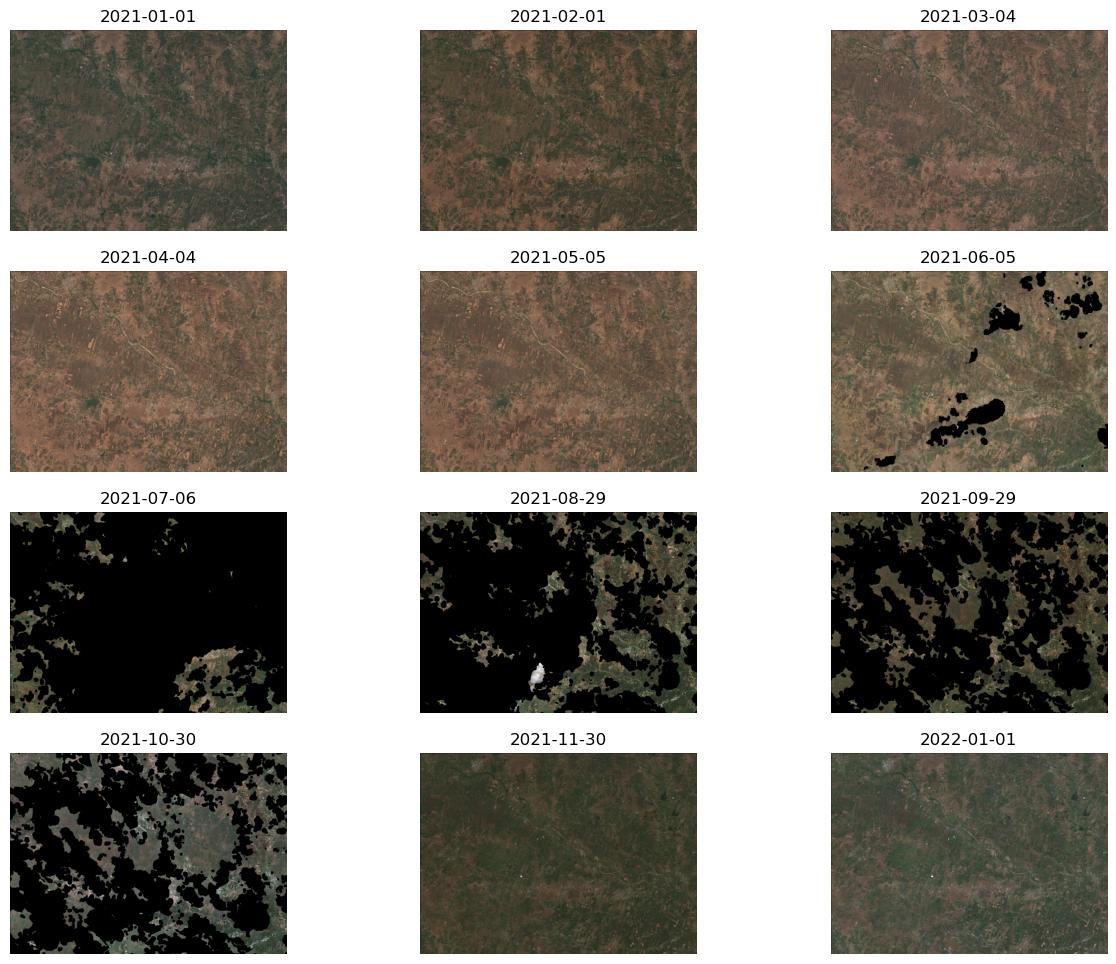

In [7]:
# Retrieve the projection geometry for the raster
with rasterio.open(spaceeye_rasters[0].raster_asset.url) as src:
    proj_geom = gpd.GeoSeries(geometry, crs="epsg:4326").to_crs(src.crs).iloc[0].envelope

# Sort assets by date
sorted_spaceeye_rasters = sorted(spaceeye_rasters, key=lambda x: x.time_range[0])

# Plot a few of them through the time_range
n_to_plot = 12
indices = np.linspace(0, len(sorted_spaceeye_rasters)-1, n_to_plot, dtype=int)

fig, ax = plt.subplots(4, 3, figsize=(15, 12))
for ax_idx, idx in enumerate(indices):
    raster = sorted_spaceeye_rasters[idx]
    ar = spaceeye_to_img(read_raster(raster, geometry=proj_geom))
    ax[ax_idx//3, ax_idx%3].set_title(f"{raster.time_range[0].strftime('%Y-%m-%d')}")
    ax[ax_idx//3, ax_idx%3].axis("off")
    ax[ax_idx//3, ax_idx%3].imshow(ar)
lw_plot()

Let's do the same for the NDVI:

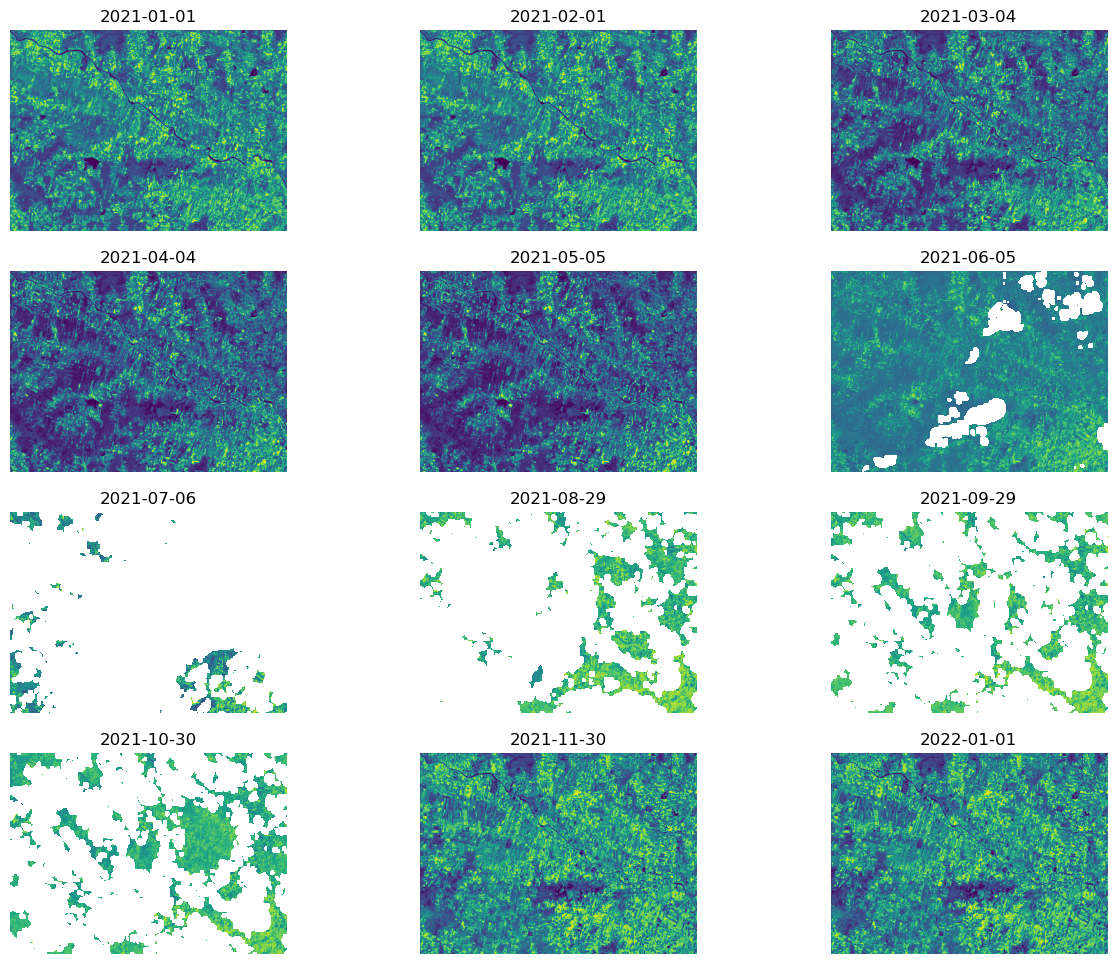

In [17]:
# Retrieve the projection geometry for the raster
with rasterio.open(ndvi_rasters[0].raster_asset.url) as src:
    proj_geom = gpd.GeoSeries(geometry, crs="epsg:4326").to_crs(src.crs).iloc[0].envelope

# Sort assets by date
sorted_ndvi_rasters = sorted(ndvi_rasters, key=lambda x: x.time_range[0])

# Plot a few of them through the time_range
fig, ax = plt.subplots(4, 3, figsize=(15, 12))

for ax_idx, idx in enumerate(indices):
    raster = sorted_ndvi_rasters[idx]
    ar = read_clip_ndvi(raster, proj_geom)
    ax[ax_idx//3, ax_idx%3].set_title(f"{raster.time_range[0].strftime('%Y-%m-%d')}")
    ax[ax_idx//3, ax_idx%3].axis("off")
    ax[ax_idx//3, ax_idx%3].imshow(ar)

-------------------------------------

## Timelapse

To get a better sense of the progression of the region throughout the time range, let's build a timelapse from the generated images using `matplotlib.animation`. 

As we might have seen in the images above, some of them have missing data represented by black/white regions. We will filter those out before generating our timelapse.

In [19]:
def get_missing_ratio(raster, proj_geom):
    ar = read_raster(raster, geometry=proj_geom, filled=False)
    c = ar.count()
    total = np.prod(ar.shape)
    return 1.0 - (c / total)

# Filtering out rasters with more than 10% of missing pixels
missing_data_thr = .1 

missing_ratio = [get_missing_ratio(raster, proj_geom) for raster in sorted_spaceeye_rasters] 
filtered_se_rasters = [se_raster for se_raster, r in zip(sorted_spaceeye_rasters, missing_ratio) if r < missing_data_thr]
filtered_ndvi_rasters = [ndvi_raster for ndvi_raster, r in zip(sorted_ndvi_rasters, missing_ratio) if r < missing_data_thr]

print(f"Filtered / Total rasters: {len(filtered_se_rasters)} / {len(sorted_spaceeye_rasters)}")

Filtered / Total rasters: 207 / 343


### SpaceEye timelapse

MovieWriter imagemagick unavailable; using Pillow instead.


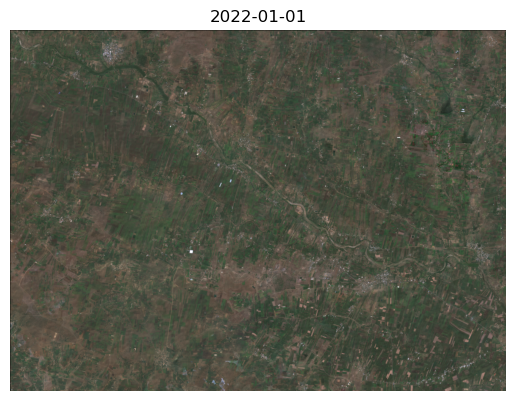

In [28]:
# Retrieve the projection geometry for the raster
with rasterio.open(spaceeye_rasters[0].raster_asset.url) as src:
    proj_geom = gpd.GeoSeries(geometry, crs="epsg:4326").to_crs(src.crs).iloc[0].envelope


# Set up the figure and axis
fig, ax = plt.subplots()

# Initialize the image plot
ar = spaceeye_to_img(read_raster(filtered_se_rasters[0], geometry=proj_geom))
im = ax.imshow(ar)
ax.set_title(f"{filtered_se_rasters[0].time_range[0].strftime('%Y-%m-%d')}")
ax.axis("off")

# Function to update the plot for each frame
def update(i):
    raster = filtered_se_rasters[i]
    ar = spaceeye_to_img(read_raster(raster, geometry=proj_geom))
    im.set_array(ar)
    ax.set_title(f"{raster.time_range[0].strftime('%Y-%m-%d')}")
    return im,

# Set up the animation using the update function
ani = animation.FuncAnimation(fig, update, frames=range(len(filtered_se_rasters)), blit=True, interval=33.33)

# Save the animation as a GIF
ani.save('timelapse_spaceeye.gif', writer='imagemagick')

Once the generation has finished, we can inspect the file or visualize the timelapse GIF with the following code:

In [ ]:
# We opted not to provide the gifs in the notebook to avoid increasing the notebook size
display(Image(filename='./timelapse_spaceeye.gif'))

### NDVI timelapse

MovieWriter imagemagick unavailable; using Pillow instead.


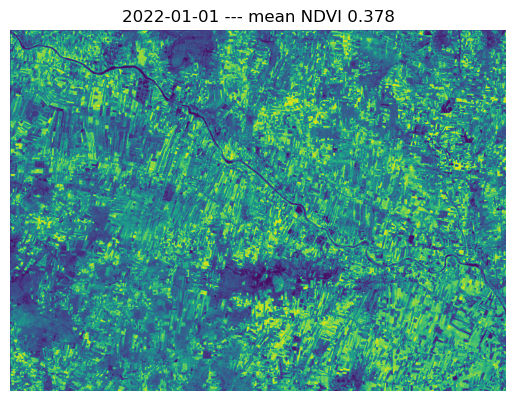

In [20]:
# Retrieve the projection geometry for the raster
with rasterio.open(ndvi_rasters[0].raster_asset.url) as src:
    proj_geom = gpd.GeoSeries(geometry, crs="epsg:4326").to_crs(src.crs).iloc[0].envelope


# Set up the figure and axis
fig, ax = plt.subplots()

# Initialize the image plot
ar = read_clip_ndvi(filtered_ndvi_rasters[0], proj_geom)

im = ax.imshow(ar)
ax.set_title(f"{filtered_ndvi_rasters[0].time_range[0].strftime('%Y-%m-%d')} --- mean NDVI {np.mean(ar):.3f}")
ax.axis("off")

# Function to update the plot for each frame
def update(i):
    raster = filtered_ndvi_rasters[i]
    ar = read_clip_ndvi(raster, proj_geom)
    im.set_array(ar)
    ax.set_title(f"{raster.time_range[0].strftime('%Y-%m-%d')} --- mean NDVI {np.mean(ar):.3f}")
    return im,

# Set up the animation using the update function
ani = animation.FuncAnimation(fig, update, frames=range(len(filtered_ndvi_rasters)), blit=True, interval=33.33)

# Save the animation as a GIF
ani.save('timelapse_ndvi.gif', writer='imagemagick')

In [ ]:
# We opted not to provide the gifs in the notebook to avoid increasing the notebook size
display(Image(filename='./timelapse_ndvi.gif'))